# ML Regression project - Store Sales Prediction (Time Series Forecasting)

## Introduction

Businesses must forecast product demand to compete. This is especially true for brick-and-mortar grocery stores, which must dance delicately with how much inventory to buy. Predict a little over, and grocers are stuck with overstocked, perishable goods. Guess a little under, and popular items quickly sell out, leading to lost revenue and upset customers. More accurate forecasting, thanks to machine learning, could help ensure retailers make the customers happy by having just enough of the right products at the right time. Everyone hates when their favourite item is out of stock.

Current subjective forecasting methods for retail have little data to back them up and are unlikely to be automated. The problem becomes even more complex as retailers add new locations with unique needs, new products, ever-transitioning seasonal tastes, and unpredictable changing market conditions.For grocery stores, more accurate forecasting can decrease food waste related to overstocking and improve customer satisfaction.

In this project, we will use regression, a specific type of supervised machine learning that focuses on predicting continuous numerical values, to predict grocery store sales for the thousands of product families sold at Favorita stores located in Ecuador. The training data includes dates, store and product information, whether that item was being promoted, as well as the sales numbers.

## 1. Business Understanding

The primary objective of this machine learning project is to develop an accurate predictive model for forecasting grocery store sales at Favorita stores in Ecuador. This model will help address the challenge faced by brick-and-mortar grocery stores in managing their inventory effectively. The goal is to predict sales for thousands of product families, considering various factors such as dates, store information, product details, and promotional activities. By achieving this objective, we aim to minimize overstocking, reduce food waste, and enhance customer satisfaction by ensuring that the right products are available in the right quantities at the right time.

For this project, we are dealing with a Time series forecasting problem. Time series forecasting involves predicting unknown values by collecting historical data, preparing it for algorithms to consume, and then predicting the future values based on patterns learned from the historical data.

We will explore different machine learning algorithms to determine the most suitable one. Potential models include but are not limited to:

1. **Time Series Forecasting**: Utilizing techniques such as ARIMA, LSTM, or Prophet to capture temporal patterns and seasonality in sales data.

2. **Regression Models**: Employing linear regression, decision trees, random forests, or gradient boosting to account for various features like promotional status, product details, and store information.

To assess the performance of the predictive model, we will use metrics such as Root Mean Squared Logarithmic Error (RMSLE), Root Mean Squared Error (RMSE) and Mean Absolute Error (MAE). The errors will be aggregated to evaluate the forecast bias. To be certain whether the model tends to underpredict or overpredict sales, which can be crucial for inventory management.

The CRISP-DM (Cross-Industry Standard Process for Data Mining) framework will guide our project, ensuring a structured and iterative approach to solving the forecasting problem. This framework encompasses phases such as Business Understanding, Data Understanding, Data Preparation, Modeling, Evaluation, Deployment, and Maintenance, allowing us to systematically develop and deploy an effective sales forecasting solution for Favorita stores in Ecuador.

### Hypothesis

**Null Hypothesis (H0)**:
"There is no significant relationship between store sales and when products are on promotion."

**Alternative Hypothesis (Ha)**:
"There is a significant relationship between store sales and when products are on promotion."

### Research Questions

1. Is the train dataset complete (has all the required dates)?

2. Which dates have the lowest and highest sales for each year?

3. Did the earthquake impact sales?

4. Are certain groups of stores selling more products? (Cluster, city, state, type)

5. Are sales affected by promotions, oil prices and holidays?

6. What analysis can we get from the date and its extractable features?

7. What is the difference between RMSLE, RMSE, MSE (or why is the MAE greater than all of them?)

## 2. Data Understanding

### Installing libraries  and Packages
Here is the section to import all the packages/libraries that will be used through this notebook.

In [1]:
# %pip install pyodbc
# %pip install python-dotenv 

In [2]:
# Database connections

import pyodbc 
from dotenv import dotenv_values #import the dotenv_values function from the dotenv package
import warnings 
warnings.filterwarnings('ignore')

# Data handling
import pandas as pd
pd.set_option('display.max_columns', None)
import openpyxl
import numpy as np
from zipfile import ZipFile

# Vizualisation (Matplotlib, Plotly, Seaborn, etc. )
import seaborn as sns
sns.set_style('whitegrid')
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
import plotly.colors as colors
from plotly.subplots import make_subplots

# EDA (pandas-profiling, etc. )
import scipy.stats as stats

# Feature Processing (Scikit-learn processing, etc. )


# Machine Learning (Scikit-learn Estimators, Catboost, LightGBM, etc. )


# Hyperparameters Fine-tuning (Scikit-learn hp search, cross-validation, etc. )


# Other packages
import os, pickle

### Data Loading
#### Accessing first dataset from the database
We want to access 3 files from a remote microsoft sql server. These are the files:

1. dbo.oil
2. dbo.holidays_events
3. dbo.stores

We will use the following packages: 

-   **pyodbc**: A package for creating connection strings to the remote database
-   **python-dotenv**: A package for creating environment variables that will help us hide sensitve configuration informantion such as database credentials and API keys

In [3]:
# Load environment variables from .env file into a dictionary
environment_variables = dotenv_values('.env')

# Get the values for the credentials you set in the '.env' file
database = environment_variables.get("DATABASE")
server = environment_variables.get("SERVER")
username = environment_variables.get("USERNAME")
password = environment_variables.get("PASSWORD")

# Create connection string to database
connection_string = f"DRIVER={{SQL Server}};SERVER=tcp:{server};DATABASE={database};UID={username};PWD={password}"

In [4]:
# Use the connect method of the pyodbc library and pass in the connection string.
# This will connect to the server and might take a few seconds to be complete. 
# Check your internet connection if it takes more time than necessary

connection = pyodbc.connect(connection_string)

In [5]:
# Get the cursor
# The connection cursor is used to execute statements to communicate with the MySQL database
cursor = connection.cursor()

# Retrieve the table names
table_names = cursor.tables(tableType='TABLE')

# Fetch all the table names
tables = table_names.fetchall()

# Print the table names
for table in tables:
    print(table.table_name)

holidays_events
oil
stores
trace_xe_action_map
trace_xe_event_map


We found our tables. Lets exctract them.

In [6]:
# sql query to get the datasets

query = "SELECT * FROM holidays_events"
query2 = "SELECT * FROM oil"
query3 = "SELECT * FROM stores"

data=pd.read_sql(query,connection)
data2=pd.read_sql(query2,connection)
data3=pd.read_sql(query3,connection)

In [7]:
# save to csv

data.to_csv('Data Tables\holidays_events.csv', index=False)
data2.to_csv('Data Tables\oil.csv', index=False)
data3.to_csv('Data Tables\stores.csv', index=False)

In [8]:
# Extract train data from zip

with ZipFile("Data Tables/train.zip", 'r') as zObject:
  
    # Extracting specific file in the zip
    zObject.extract(
        "train.csv", path="Data Tables")
zObject.close()

#### Data Loading

In [9]:
# Change date column from object to date type

holidays=pd.read_csv("Data Tables/holidays_events.csv", parse_dates =['date'])
oil=pd.read_csv("Data Tables/oil.csv", parse_dates =['date'])
sample=pd.read_csv("Data Tables/sample_submission.csv")
stores=pd.read_csv("Data Tables/stores.csv")
test=pd.read_csv("Data Tables/test.csv", parse_dates =['date'])
train=pd.read_csv("Data Tables/train.csv", parse_dates =['date'])
transactions=pd.read_csv("Data Tables/transactions.csv", parse_dates =['date'])

### Exploratory Data Analysis

##### Training data

In [10]:
train.head()

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,1,2013-01-01,1,BABY CARE,0.0,0
2,2,2013-01-01,1,BEAUTY,0.0,0
3,3,2013-01-01,1,BEVERAGES,0.0,0
4,4,2013-01-01,1,BOOKS,0.0,0


In [11]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000888 entries, 0 to 3000887
Data columns (total 6 columns):
 #   Column       Dtype         
---  ------       -----         
 0   id           int64         
 1   date         datetime64[ns]
 2   store_nbr    int64         
 3   family       object        
 4   sales        float64       
 5   onpromotion  int64         
dtypes: datetime64[ns](1), float64(1), int64(3), object(1)
memory usage: 137.4+ MB


- Features and descriptions of train and test dataset

| Feature            | Description                                                                                                      |
| ---------------- | ---------------------------------------------------------------------------------------------------------------- |
| store_nbr           | identifies the store at which the products are sold.                                                                       |
| family    | identifies the type of product sold.                                                                    |
| sales          | gives the total sales for a product family at a particular store at a given date. Fractional values are possible since products can be sold in fractional units (1.5 kg of cheese, for instance, as opposed to 1 bag of chips).                                                              |
| onpromotion       | gives the total number of items in a product family that were being promoted at a store at a given date.                                                             |



In [12]:
# Check for missing values using isna()
missing_values = train.isna().sum()

# Count missing values in each column
missing_counts = missing_values.sum()

# Check if there are any missing values in the entire DataFrame
any_missing = missing_values.any().any()

print("Missing Values in DataFrame:")
print(missing_values)
print("\nMissing Value Counts in Each Column:")
print(missing_counts)
print("\nAre there any missing values in the DataFrame?", any_missing)

Missing Values in DataFrame:
id             0
date           0
store_nbr      0
family         0
sales          0
onpromotion    0
dtype: int64

Missing Value Counts in Each Column:
0

Are there any missing values in the DataFrame? False


- No missing values in train dataset

In [13]:
train.describe()

,id,date,store_nbr,sales,onpromotion
count,3.000888e+06,3000888,3.000888e+06,3.000888e+06,3.000888e+06
mean,1.500444e+06,2015-04-24 08:27:04.703088384,2.750000e+01,3.577757e+02,2.602770e+00
min,0.000000e+00,2013-01-01 00:00:00,1.000000e+00,0.000000e+00,0.000000e+00
25%,7.502218e+05,2014-02-26 18:00:00,1.400000e+01,0.000000e+00,0.000000e+00
50%,1.500444e+06,2015-04-24 12:00:00,2.750000e+01,1.100000e+01,0.000000e+00
75%,2.250665e+06,2016-06-19 06:00:00,4.100000e+01,1.958473e+02,0.000000e+00
max,3.000887e+06,2017-08-15 00:00:00,5.400000e+01,1.247170e+05,7.410000e+02
std,8.662819e+05,NaN,1.558579e+01,1.101998e+03,1.221888e+01


#### Let us start by plotting frequencies of data point on yearly/monthly basis

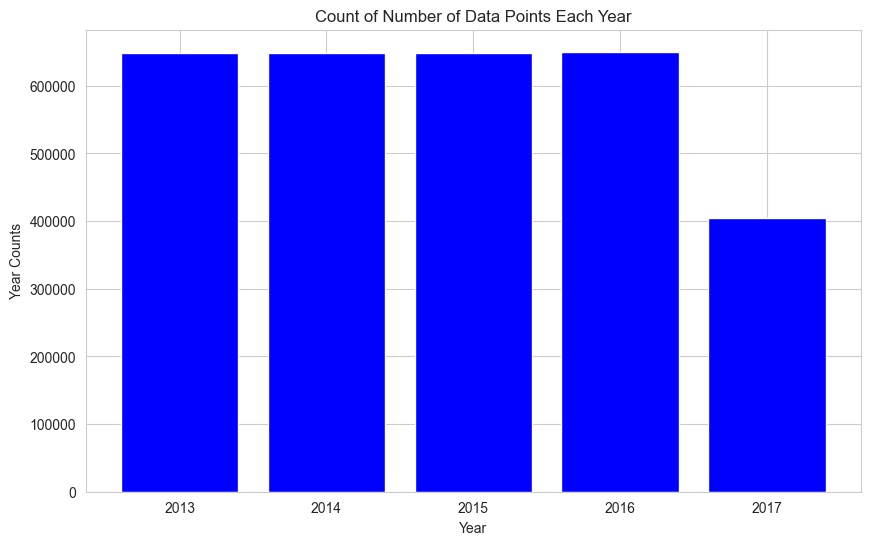

In [14]:
# extracting the year column
train['year'] = pd.to_datetime(train['date']).dt.year

# Grouping by year and count the data points
year_data = train.groupby('year').size().reset_index(name='counts')

# Plotting the data
fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(year_data['year'], year_data['counts'], color='blue')
ax.set_xticks(year_data['year'])
ax.set_title('Count of Number of Data Points Each Year')
ax.set_xlabel('Year')
ax.set_ylabel('Year Counts')

plt.show()

- There has been a uniformity of data counts from 2013-2016 but the count dropped in 2017

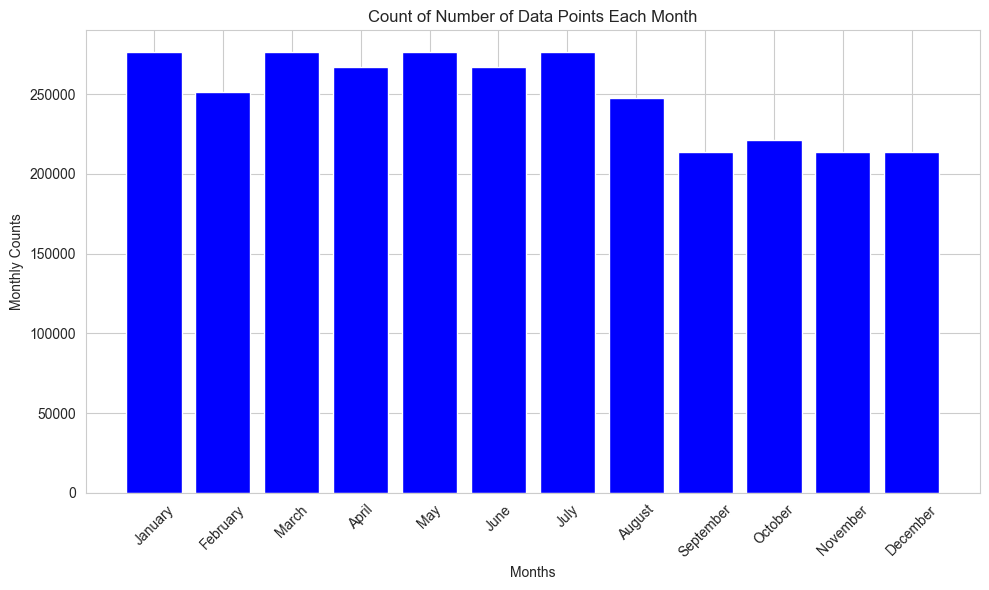

In [15]:
# extracting the month
train['month'] = pd.to_datetime(train['date']).dt.month

# Grouping by month and count the data points
monthly_data = train.groupby('month').size().reset_index(name='counts')

# Renaming the month values for labeling
month_names = [
    'January', 'February', 'March', 'April', 'May', 'June',
    'July', 'August', 'September', 'October', 'November', 'December'
]
monthly_data['month'] = monthly_data['month'].apply(lambda x: month_names[x - 1])

# Plotting the data
fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(monthly_data['month'], monthly_data['counts'], color='blue')
ax.set_title('Count of Number of Data Points Each Month')
ax.set_xlabel('Months')
ax.set_ylabel('Monthly Counts')

plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout()  # Ensure labels are not cut off

plt.show()

- There is some uniformity in distribution of datapoints across the months

#### Total sales by store

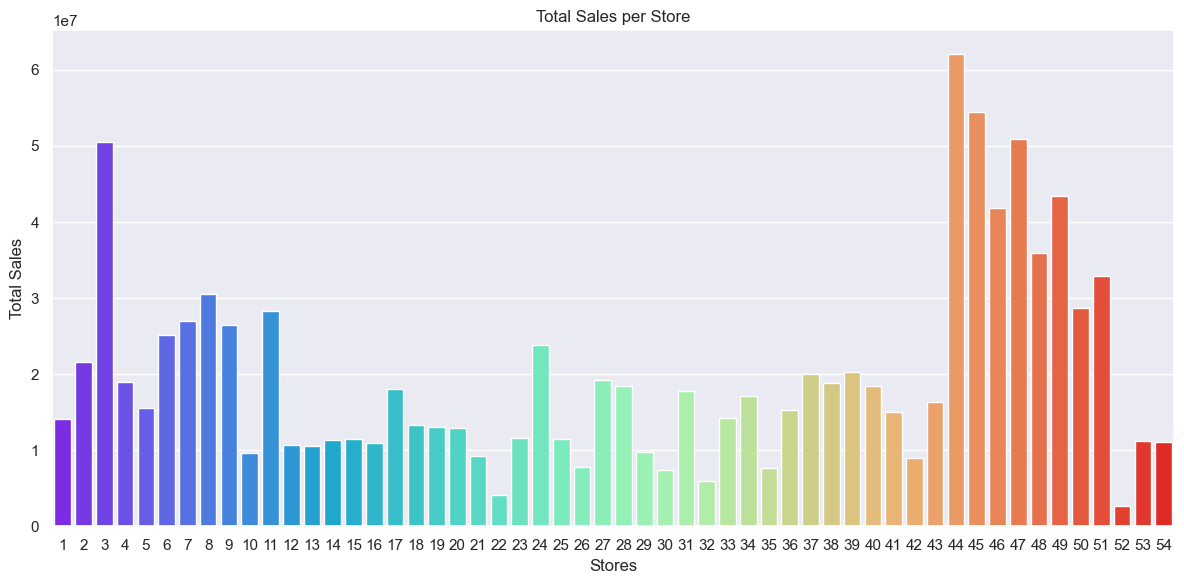

In [16]:
# Filter rows where unit_sales > 0
train = train[train['sales'] > 0]

# Group by 'store_nbr' and calculate the sum of 'unit_sales'
store_unit_sales = train.groupby('store_nbr')['sales'].sum().reset_index()

# Set the figure size
sns.set(rc={'figure.figsize': (12, 6)})

# Create a barplot
sns.barplot(x='store_nbr', y='sales', data=store_unit_sales, palette='rainbow')

# Set titles and labels
plt.title('Total Sales per Store')
plt.xlabel('Stores')
plt.ylabel('Total Sales')

# Show the plot

plt.tight_layout()
plt.show()

- We can say Store number 3,44,45,46,47,48,49, 51 have the highest volume of sales

#### Unit sales daily

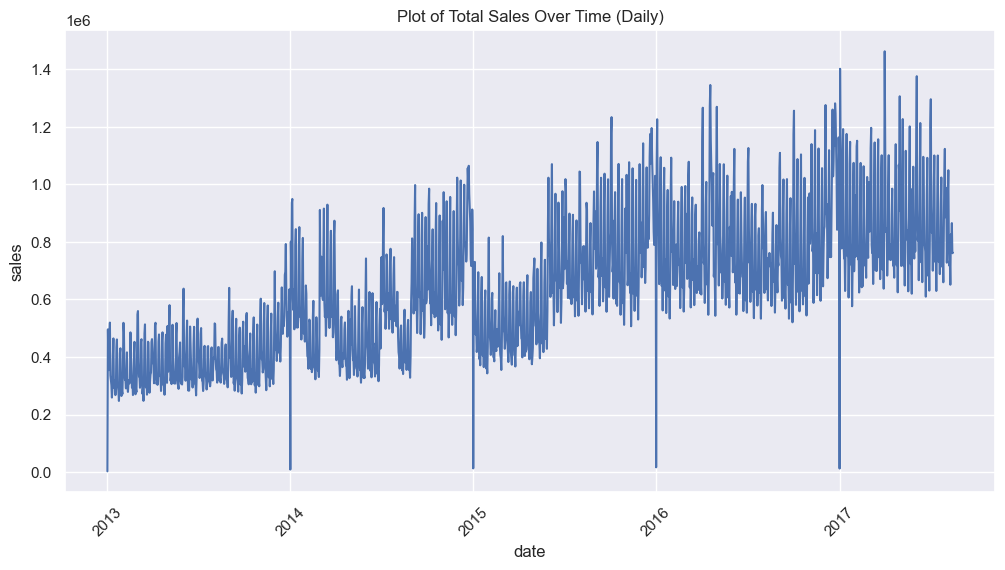

In [17]:
# Filter rows where unit_sales > 0
train = train[train['sales'] > 0]

# Group by 'date' and calculate the sum of 'sales'
sales_date_agg = train.groupby('date')['sales'].sum().reset_index()

# Set the figure size
sns.set(rc={'figure.figsize': (12, 6)})

# Create a lineplot
sns.lineplot(x='date', y='sales', data=sales_date_agg)

# Set the title
plt.title('Plot of Total Sales Over Time (Daily)')

# Rotate x-axis labels for better readability (if needed)
plt.xticks(rotation=45)

# Show the plot
plt.show()


- upward trend year on year

##### Test data

- The test data, has the same features as the training data, except sales,  which we will predict the target sales for the dates in this file.

- The dates in the test data are for the 15 days after the last date in the training data.

In [18]:
test.head()

,id,date,store_nbr,family,onpromotion
0,3000888,2017-08-16,1,AUTOMOTIVE,0
1,3000889,2017-08-16,1,BABY CARE,0
2,3000890,2017-08-16,1,BEAUTY,2
3,3000891,2017-08-16,1,BEVERAGES,20
4,3000892,2017-08-16,1,BOOKS,0


In [19]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28512 entries, 0 to 28511
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   id           28512 non-null  int64         
 1   date         28512 non-null  datetime64[ns]
 2   store_nbr    28512 non-null  int64         
 3   family       28512 non-null  object        
 4   onpromotion  28512 non-null  int64         
dtypes: datetime64[ns](1), int64(3), object(1)
memory usage: 1.1+ MB


In [20]:
# check for missing values

test.isna().sum()

id             0
date           0
store_nbr      0
family         0
onpromotion    0
dtype: int64

##### Transactions Dataset

- Contains date, store_nbr and transaction made on that specific date.

In [21]:
transactions.head()

,date,store_nbr,transactions
0,2013-01-01,25,770
1,2013-01-02,1,2111
2,2013-01-02,2,2358
3,2013-01-02,3,3487
4,2013-01-02,4,1922


In [22]:
transactions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83488 entries, 0 to 83487
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   date          83488 non-null  datetime64[ns]
 1   store_nbr     83488 non-null  int64         
 2   transactions  83488 non-null  int64         
dtypes: datetime64[ns](1), int64(2)
memory usage: 1.9 MB


In [23]:
# check for missing values

transactions.isna().sum()

date            0
store_nbr       0
transactions    0
dtype: int64

##### Stores Dataset

- Store metadata, including city, state, type, and cluster.

- cluster is a grouping of similar stores.

In [24]:
stores.head()

,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4


In [25]:
stores.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54 entries, 0 to 53
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   store_nbr  54 non-null     int64 
 1   city       54 non-null     object
 2   state      54 non-null     object
 3   type       54 non-null     object
 4   cluster    54 non-null     int64 
dtypes: int64(2), object(3)
memory usage: 2.2+ KB


In [26]:
# check for missing values

stores.isna().sum()

store_nbr    0
city         0
state        0
type         0
cluster      0
dtype: int64

##### Oil Dataset

- Daily oil price which includes values during both the train and test data timeframes. (Ecuador is an oil-dependent country and its economical health is highly vulnerable to shocks in oil prices.)

In [27]:
oil.head()

,date,dcoilwtico
0,2013-01-01,NaN
1,2013-01-02,93.139999
2,2013-01-03,92.970001
3,2013-01-04,93.120003
4,2013-01-07,93.199997


In [28]:
oil.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1218 entries, 0 to 1217
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   date        1218 non-null   datetime64[ns]
 1   dcoilwtico  1175 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 19.2 KB


In [29]:
# check for missing values

oil.isna().sum()

date           0
dcoilwtico    43
dtype: int64

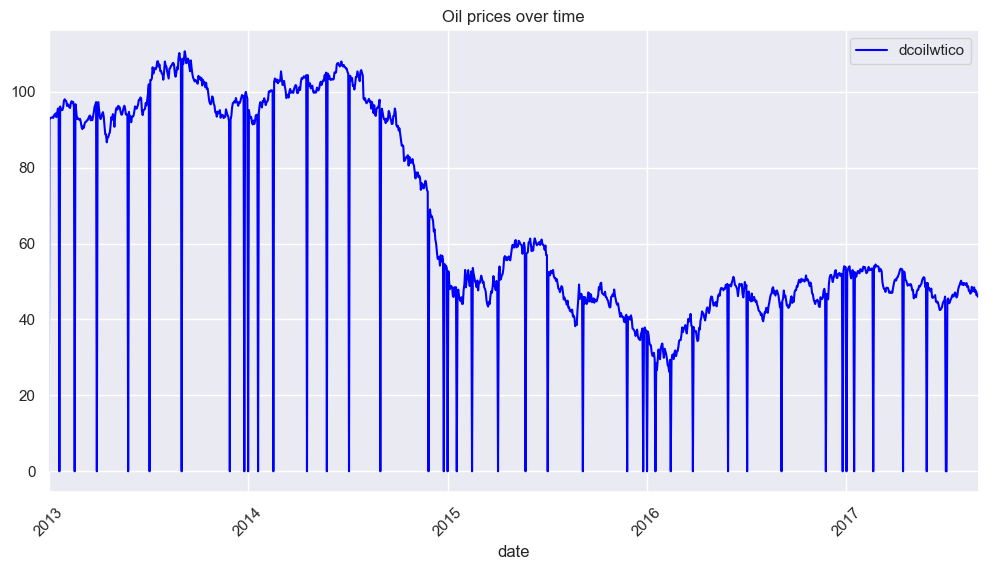

In [30]:
# Oil prices

ax = oil.groupby(['date'], as_index=False)["dcoilwtico"].sum().plot(
    "date", "dcoilwtico", figsize=(12,6), title="Oil prices over time", color='blue')

plt.tick_params(axis='x', labelrotation=45)

##### Holiday/Events Dataset

- Holidays and Events, with metadata

NOTE: Pay special attention to the transferred column. A holiday that is transferred officially falls on that calendar day but was moved to another date by the government. A transferred day is more like a normal day than a holiday. To find the day that it was celebrated, look for the corresponding row where type is Transfer.

For example, the holiday Independencia de Guayaquil was transferred from 2012-10-09 to 2012-10-12, which means it was celebrated on 2012-10-12. Days that are type Bridge are extra days that are added to a holiday (e.g., to extend the break across a long weekend). These are frequently made up by the type Work Day which is a day not normally scheduled for work (e.g., Saturday) that is meant to payback the Bridge.

- Additional holidays are days added a regular calendar holiday, for example, as typically happens around Christmas (making Christmas Eve a holiday).

In [31]:
holidays.head()

,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False


In [32]:
holidays.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 350 entries, 0 to 349
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   date         350 non-null    datetime64[ns]
 1   type         350 non-null    object        
 2   locale       350 non-null    object        
 3   locale_name  350 non-null    object        
 4   description  350 non-null    object        
 5   transferred  350 non-null    bool          
dtypes: bool(1), datetime64[ns](1), object(4)
memory usage: 14.1+ KB


In [33]:
# check for missing values

holidays.isna().sum()

date           0
type           0
locale         0
locale_name    0
description    0
transferred    0
dtype: int64

### Analytical Questions

1. Is the train dataset complete (has all the required dates)?

In [34]:
# Check for missing values
if train.isnull().values.any():
  print("The dataset is not complete. There are missing values.")

# Check for missing dates in a time-series dataset
if not train.index.is_unique:
  print("The dataset is not complete. There are duplicate dates.")
else:
  print("The dataset is complete.")

The dataset is complete.


2. Which dates have the lowest and highest sales for each year?

In [35]:
# Highest sales each year

train_reset_i = train.reset_index()
max_sales = train_reset_i.groupby(lambda x: train_reset_i['date'][x].year)["sales"].idxmax()
Result_max = train_reset_i.loc[max_sales]
Result_max

,index,id,date,store_nbr,family,sales,onpromotion,year,month
277783,562596,562596,2013-11-12,44,GROCERY I,46271.000,0,2013,11
699334,1257246,1257246,2014-12-08,35,GROCERY I,45361.000,3,2014,12
1163500,1916586,1916586,2015-12-14,35,GROCERY I,40351.460,7,2015,12
1364957,2163723,2163723,2016-05-02,2,GROCERY I,124717.000,59,2016,5
1854994,2760297,2760297,2017-04-02,9,GROCERY I,38422.625,73,2017,4


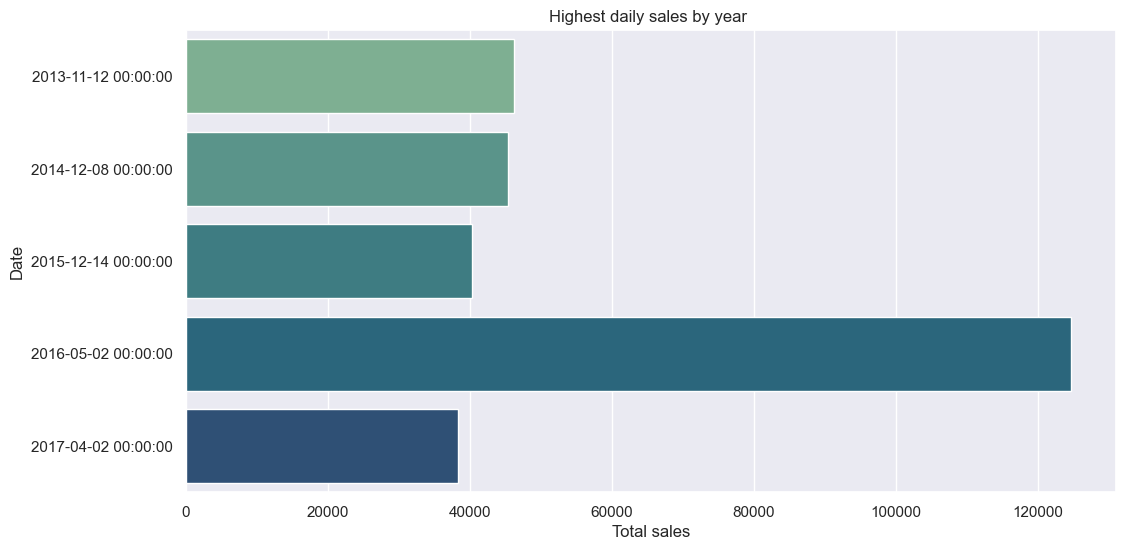

In [36]:
sns.barplot(data=Result_max, y="date", x="sales", palette='crest')
plt.ylabel("Date")
plt.xlabel("Total sales")
plt.title("Highest daily sales by year ")
plt.show()

- 2016(11/12) has the highest number of sales (124,717)

In [37]:
# lowest sales each year
min_sales = train_reset_i.groupby(lambda x: train_reset_i['date'][x].year)["sales"].idxmin()
Result_min = train_reset_i.loc[min_sales]
Result_min

,index,id,date,store_nbr,family,sales,onpromotion,year,month
190264,387782,387782,2013-08-06,39,SEAFOOD,0.122,0,2013,8
695585,1252052,1252052,2014-12-05,39,SEAFOOD,0.188,0,2014,12
1033680,1756358,1756358,2015-09-15,39,SEAFOOD,0.196,0,2015,9
1441800,2256638,2256638,2016-06-23,26,SEAFOOD,0.396,1,2016,6
1775923,2666498,2666498,2017-02-09,26,SEAFOOD,0.426,0,2017,2


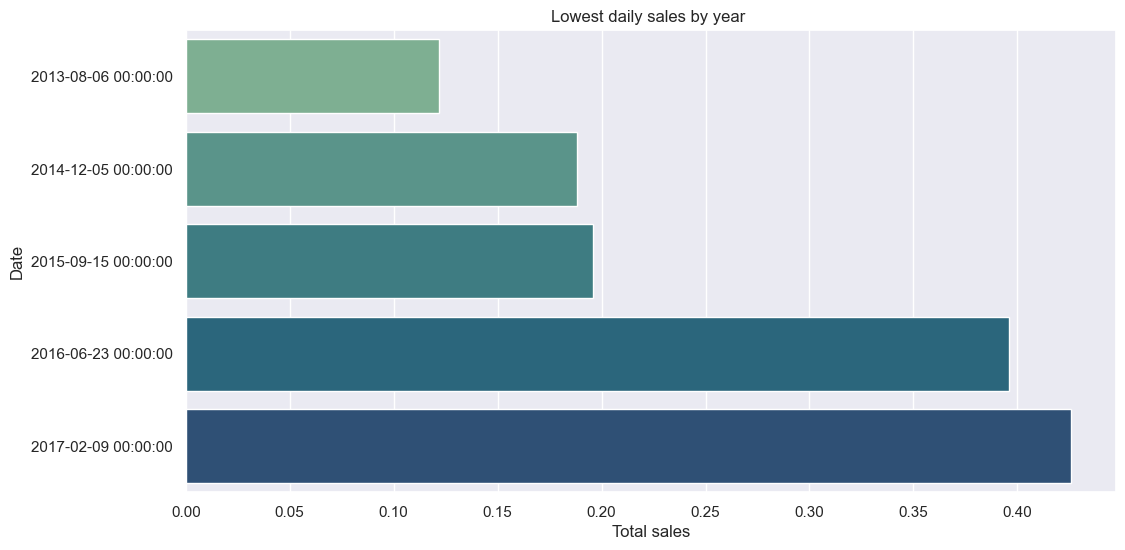

In [38]:
sns.barplot(data=Result_min, y="date", x="sales", palette='crest')
plt.ylabel("Date")
plt.xlabel("Total sales")
plt.title("Lowest daily sales by year ")
plt.show()

- 2013(09/06) has the lowest number of sales (0.122)

3. Did the earthquake impact sales?

The 2016 Ecuador earthquake occurred on April 16 at 18:58:37 ECT with a moment magnitude of 7.8

In [41]:
# Daily and weekly average sales

sales_daily_mean = train["sales"].resample('D').mean()
sales_weekly_mean = train["sales"].resample('W').mean()


TypeError: Only valid with DatetimeIndex, TimedeltaIndex or PeriodIndex, but got an instance of 'Index'

Text(0.5, 1.0, 'April and May 2016 sales')

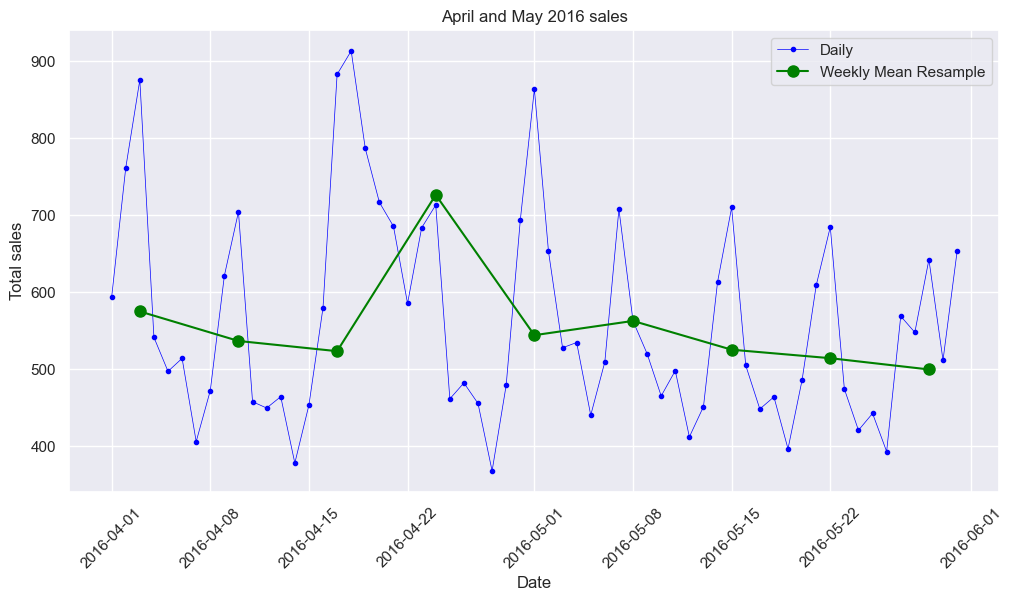

In [ ]:
# Sales for April to May 2016.
start, end = '2016-04', '2016-05'

# Analyse before and after the earthquake

fig, ax = plt.subplots(figsize=(12,6))

color_daily = 'blue'
color_weekly = 'green'

ax.plot(sales_daily_mean.loc[start:end], marker='.', linestyle='-', linewidth=0.5, label='Daily', color=color_daily)
ax.plot(sales_weekly_mean.loc[start:end], marker='o', markersize=8, linestyle='-', label='Weekly Mean Resample', color=color_weekly)
ax.set_ylabel("Total sales")
ax.set_xlabel("Date")
ax.tick_params(axis='x', labelrotation=45)
ax.legend()
ax.set_title("April and May 2016 sales")

In the week of the earthquake (from April 14th to April 21st), sales increased during this week, reaching a peak on the day of the earthquake (16th), but then experienced a sharp decline for nearly two weeks following the earthquake, returning to normalcy.

4. Are certain groups of stores selling more products? (Cluster, city, state, type)

In [ ]:
# sort sales of product by store number

stores_product = train.groupby(["store_nbr", "family"])["sales"].sum()

train_stores = pd.merge(train, stores)

train_stores.head()


,id,store_nbr,family,sales,onpromotion,year,month,city,state,type,cluster
0,563,25,BEAUTY,2.000,0,2013,1,Salinas,Santa Elena,D,1
1,564,25,BEVERAGES,810.000,0,2013,1,Salinas,Santa Elena,D,1
2,566,25,BREAD/BAKERY,180.589,0,2013,1,Salinas,Santa Elena,D,1
3,568,25,CLEANING,186.000,0,2013,1,Salinas,Santa Elena,D,1
4,569,25,DAIRY,143.000,0,2013,1,Salinas,Santa Elena,D,1


#### Store sales by cluster

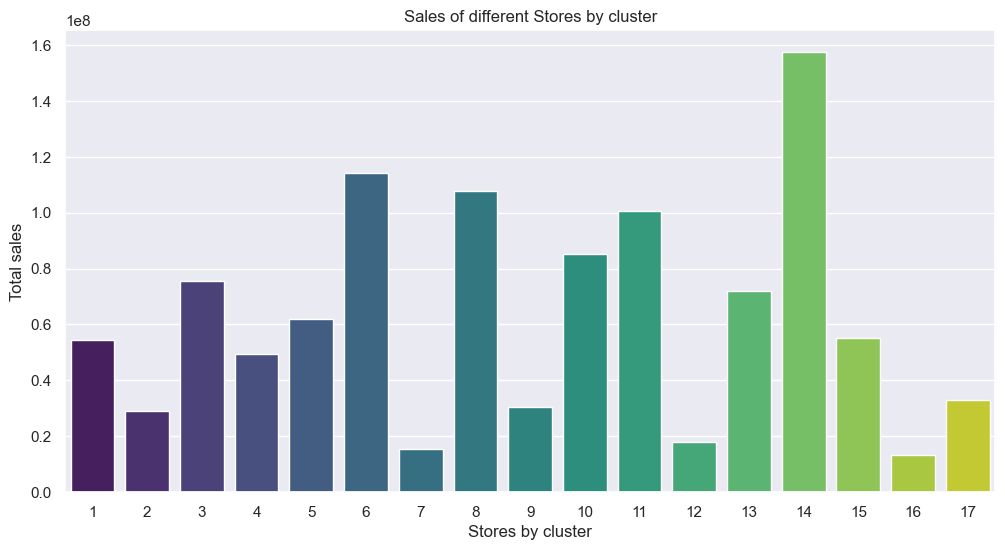

In [ ]:
sales_clusters = train_stores.groupby("cluster", as_index=False)["sales"].sum()

sns.barplot(data=sales_clusters, x = "cluster", y = "sales", palette='viridis')
plt.xlabel("Stores by cluster")
plt.ylabel("Total sales")
plt.title("Sales of different Stores by cluster")
plt.show()

- cluster 14 has the highest sales. cluster 16 has the lowest sales.

#### Store sales by city

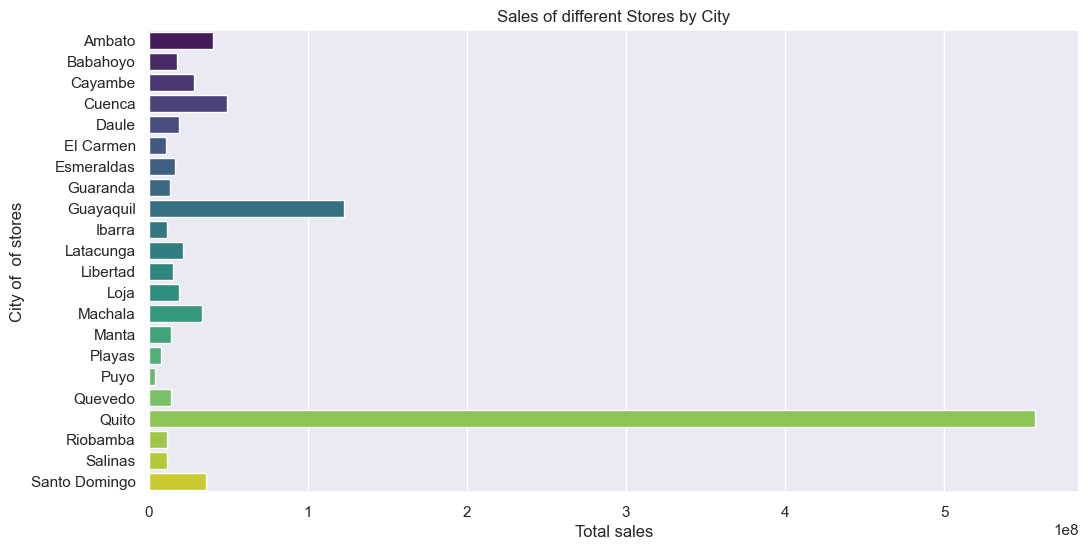

In [ ]:
sales_city = train_stores.groupby("city", as_index=False)["sales"].sum()

sns.barplot(data=sales_city, y = "city", x = "sales", palette='viridis')
plt.ylabel("City of  of stores")
plt.xlabel("Total sales")
plt.title("Sales of different Stores by City")
plt.show()

- Quito has the highest total sales, as it is the capital, and Puyo the lowest

#### Store sales by state

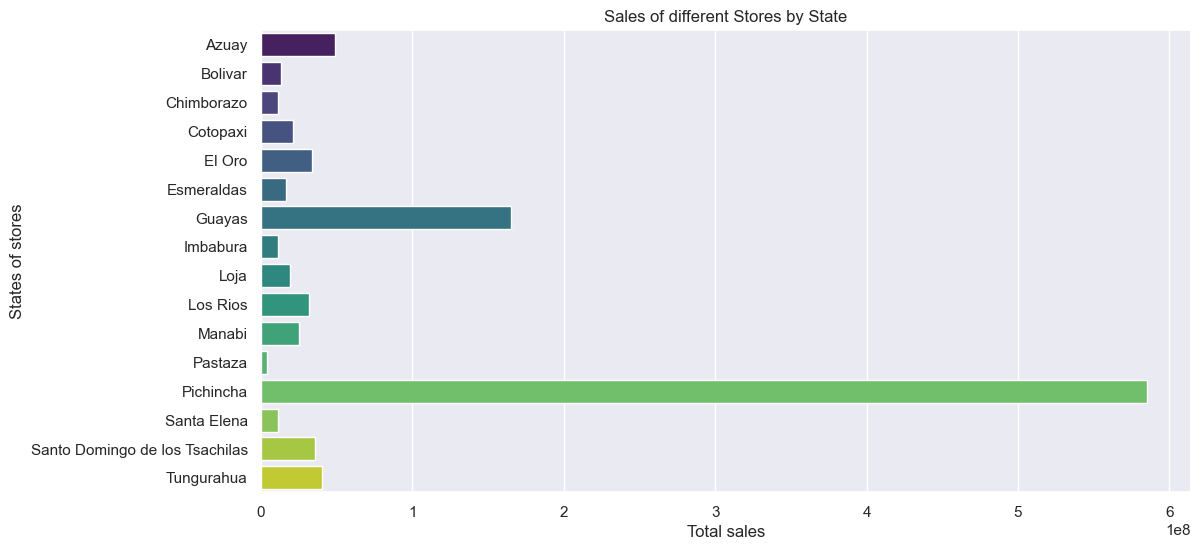

In [ ]:
sales_state = train_stores.groupby("state", as_index=False)["sales"].sum()

sns.barplot(data=sales_state, y = "state", x = "sales", palette='viridis')
plt.ylabel("States of stores")
plt.xlabel("Total sales")
plt.title("Sales of different Stores by State")
plt.show()

- Pichincha has the highest total sales
- Pastaza has the lowest total sales

#### Store sales by type

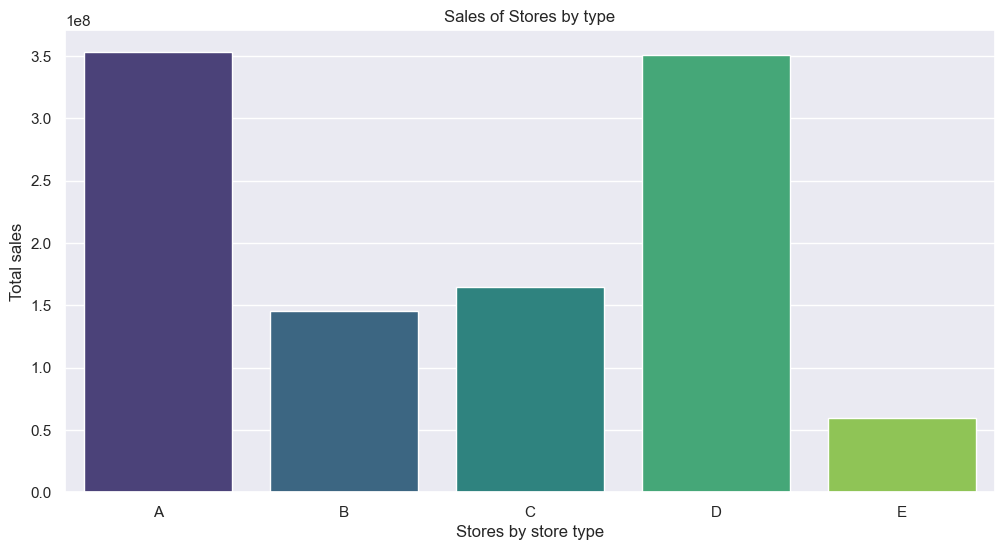

In [ ]:
sales_type = train_stores.groupby("type", as_index=False)["sales"].sum()

sns.barplot(data=sales_type, x = "type", y = "sales", palette='viridis')
plt.xlabel("Stores by store type")
plt.ylabel("Total sales")
plt.title("Sales of Stores by type")
plt.show()

- type A nd D have the highest total sales

5. Are sales affected by promotions, oil prices and holidays?

6. What analysis can we get from the date and its extractable features?

7. What is the difference between RMSLE, RMSE, MSE (or why is the MAE greater than all of them?)

- MSE( Mean Squared Error) is a widely used metric for regression problems.
It measures the average of the squared differences between predicted and actual values.
MSE is sensitive to outliers because it squares the differences.

- RMSE (Root Mean Squared Error) is the square root of the MSE.
It's often used because it has the same unit of measurement as the target variable, which makes it more interpretable.
RMSE treats all errors equally.

- RMSLE (Root Mean Squared Logarithmic Error) is commonly used when you want to penalize underpredictions more than overpredictions and when the target variable has a wide range.
It first takes the natural logarithm of the predicted and actual values and then computes the RMSE of those log values. RMSLE takes the logarithm of the values before computing the error, which can be useful when dealing with skewed data or when you want to give less weight to large errors for large values

-  MSE is greater because it is calculated as the average of the squared differences between predicted and actual values. When you square the differences between predicted and actual values, even small errors get larger because negative differences (i.e., underpredictions) become positive. Large errors, in particular, contribute significantly to the MSE

## 3. Data Preparation

In [ ]:
# shape overview to doubleckeck

train.shape, test.shape

((2061758, 8), (28512, 5))

- Our test data is without the target variable, which is ok

In [ ]:
# check for duplicates

train.duplicated().any(), 
stores.duplicated().any(), 
oil.duplicated().any(),  
test.duplicated().any(),  
holidays.duplicated().any(),
transactions.duplicated().any()

False

In [ ]:
# # check for missing values in train data
# # we know our test data doesn't have any missing values

# train.isna().sum()

In [ ]:
# # we had some missing values in the oil dataset

# oil['dcoilwtico'].isna().sum()

In [ ]:
# #Filling missing values in oil data with the the value before that missing data

# oil= oil.bfill()

In [ ]:
# # check again to confirm

# oil['dcoilwtico'].isna().sum()

In [ ]:
# oil.head()

In [ ]:
# missing_dates_train = (pd.date_range(
#     start=train.date.min(),
#     end=train.date.max())
#     .difference(train.date)
# )
# missing_dates_train